# Main housing construction period

In [1]:
from pynsee.download import get_file_list, get_column_metadata, download_file
from pynsee.geodata import get_geodata, get_geodata_list
from pynsee.geodata import GeoFrDataFrame

import py7zr
import tempfile
import os
import re
import shutil
import math
import urllib.request as request
from contextlib import closing
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from pandas.api.types import CategoricalDtype
import matplotlib.cm as cm
import matplotlib.pyplot as plt

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import logging
import sys
logging.basicConfig(stream=sys.stdout,
                    level=logging.INFO, 
                    format="%(message)s")

In [3]:
meta = get_file_list()
metacol = get_column_metadata("RP_LOGEMENT_2016")

INSEE API credentials have not been found: please try to reuse pynsee.init_conn to save them locally.
Otherwise, you can still use environment variables as follow:

import os
os.environ['sirene_key'] = 'my_sirene_key'
https://minio.lab.sspcloud.fr/pierrelamarche/melodi/liste_donnees.json
https://raw.githubusercontent.com/InseeFrLab/DoReMIFaSol/master/data-raw/liste_donnees.json
pynsee.download's metadata rely on volunteering contributors and their manual updates. get_file_list does not provide data from official Insee's metadata API
Consequently, please report any issue
Column-specific metadata has been found for this file


In [4]:
meta_achl = metacol[metacol["column"] == "ACHL"].reset_index(drop=True)
meta_achl.loc[~meta_achl["value"].isin(["A11", "A12", "B11", "B12", "C100"]), "value"] = ">2005"
meta_achl.loc[meta_achl["value"] == ">2005", "value_label_fr"] = "Après 2005"
meta_achl = meta_achl[["value", "value_label_fr"]].drop_duplicates()
meta_achl.columns = ["ACHL", "ACHL_label_fr"]
meta_achl

,ACHL,ACHL_label_fr
0,A11,Avant 1919
1,A12,De 1919 à 1945
2,B11,De 1946 à 1970
3,B12,De 1971 à 1990
4,C100,De 1991 à 2005
5,>2005,Après 2005


In [5]:
df = download_file("RP_LOGEMENT_2017", variables = ["COMMUNE", "IRIS", "ACHL", "IPONDL"])
DF = df[["COMMUNE", "IRIS", "ACHL", "IPONDL"]].reset_index(drop=True)
DF["IPONDL"] = pd.to_numeric(DF["IPONDL"])
DF = DF.groupby(["COMMUNE", "IRIS", "ACHL"], as_index=False).IPONDL.agg("sum")

Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/4748274eba51ad29ca3d426ca5bb1ba3.parquet
Creation date: 2025-06-28, today
Set update=True to get the most up-to-date data


In [6]:
pondTot = DF.groupby(["COMMUNE", "IRIS"], as_index=False)['IPONDL'].agg('sum')
pondTot = pondTot.rename(columns={'IPONDL': 'pondTot'})
DF = DF.merge(pondTot, on = ["COMMUNE", "IRIS"], how='left')

In [7]:
DF["pct"] = DF["IPONDL"] / DF["pondTot"] * 100
DF.loc[~DF["ACHL"].isin(["A11", "A12", "B11", "B12", "C100"]), "ACHL"] = ">2005"
data = DF.groupby(["COMMUNE", "IRIS", "ACHL"], as_index=False).pct.agg("sum")
data = data.merge(meta_achl, on = "ACHL", how="left")
data.loc[data["IRIS"] == "ZZZZZZZZZ", "IRIS"] = "0000"
data["CODE_IRIS"] = data["IRIS"]
data.loc[data["IRIS"] == "0000", "CODE_IRIS"] = data.loc[data["IRIS"] == "0000", "COMMUNE"] + data.loc[data["IRIS"] == "0000", "IRIS"]

#data.head(10)

In [8]:
data.head(10)

,COMMUNE,IRIS,ACHL,pct,ACHL_label_fr,CODE_IRIS
0,01001,0000,>2005,7.141565,Après 2005,010010000
1,01001,0000,A11,28.765250,Avant 1919,010010000
2,01001,0000,A12,3.160147,De 1919 à 1945,010010000
3,01001,0000,B11,3.445027,De 1946 à 1970,010010000
4,01001,0000,B12,29.377355,De 1971 à 1990,010010000
5,01001,0000,C100,28.110656,De 1991 à 2005,010010000
6,01002,0000,>2005,9.469609,Après 2005,010020000
7,01002,0000,A11,62.087134,Avant 1919,010020000
8,01002,0000,A12,10.058386,De 1919 à 1945,010020000
9,01002,0000,B11,4.744642,De 1946 à 1970,010020000


In [9]:
import os
import shutil
from pathlib import Path
from urllib.request import Request, urlopen
from contextlib import closing

ign_iris_2022 = "https://data.geopf.fr/telechargement/download/CONTOURS-IRIS/CONTOURS-IRIS_2-1__SHP__FRA_2022-01-01/CONTOURS-IRIS_2-1__SHP__FRA_2022-01-01.7z"

def get_iris_data(url=ign_iris_2022, update=False):
    list_string_split = url.split("/")
    filename = list_string_split[-1]
    list_string_split_filename = filename.split(".")
    filename_clean = list_string_split_filename[0]
    
    home = Path.home()
    dataDir = os.path.join(home, filename_clean)
    if not os.path.exists(dataDir):
        os.mkdir(dataDir)

    file_iris = os.path.join(dataDir, "file_" + filename_clean)

    req = Request(
        url=url, 
        headers={'User-Agent': 'Mozilla/5.0'},
    )
        
    if not os.path.exists(file_iris) or update:
        with closing(urlopen(req)) as r:
            with open(file_iris, 'wb') as f:
                shutil.copyfileobj(r, f)

    with py7zr.SevenZipFile(file_iris, mode='r') as z:
            z.extractall(dataDir)

    list_file = []
    list_file_size = []

    for root, d_names, f_names in os.walk(dataDir):
        for f in f_names:
            filename = root + "/" + f
            if re.search("CONTOURS-IRIS.shp", filename):
                list_file += [filename]
                list_file_size += [os.path.getsize(filename)]
    
    list_shp_df = []
                
    for f in list_file:  
               
        shp = gpd.read_file(f)
        shp = shp.to_crs("EPSG:3857")
        list_shp_df += [shp]
        
    shpFinal = pd.concat(list_shp_df)

    return shpFinal


In [11]:
shapefile = get_iris_data(update=True)

In [12]:
shp = shapefile.sort_values(by = ["INSEE_COM"]).reset_index(drop=True)
shp.loc[shp["IRIS"] == "0000", "IRIS"] = "ZZZZZZZZZ"
shp.rename(columns={'INSEE_COM':'COMMUNE'}, inplace=True)

In [22]:
data['pct_max'] = data.groupby(['COMMUNE', "IRIS"])['pct'].transform("max")
dataMax = data[data["pct"] == data["pct_max"]].reset_index(drop=True)

list_dep_extract = []
for i in dataMax.index:
    dep = dataMax["COMMUNE"].values[i][:3]    
    if not re.search("^97", dep):
        dep = dataMax["COMMUNE"].values[i][:2]          
    list_dep_extract += [dep]
    
dataMax["insee_dep"] = list_dep_extract

dataFinal = dataMax.merge(shp[["CODE_IRIS", "geometry", "NOM_COM"]], on=["CODE_IRIS"], how = "left")

In [23]:
dataFinal["crsCoord"] = "EPSG:3857"
dataFinal = dataFinal.reset_index(drop=True)

In [16]:
com = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune')

Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/6cb5dc200198fcdb00222fe8b8f7945b.parquet
Creation date: 2025-06-28, today
Set update=True to get the most up-to-date data


In [24]:
list_com = dataFinal.loc[dataFinal["geometry"].isnull()].COMMUNE.unique()

for c in list_com:
    dc = dataFinal[dataFinal["COMMUNE"] == c].reset_index(drop=True)
    if not dc.empty:
        geo = com[com["code_insee"] == c]
        if not geo.empty:
            dataFinal.loc[(dataFinal["COMMUNE"] == c), "geometry"] = geo.geometry

In [25]:
dataFinal = dataFinal[~dataFinal.geometry.isnull()]
dataFinal = GeoFrDataFrame(dataFinal).transform_overseas()
dataFinal = dataFinal.zoom(["75","92", "93", "91", "77", "78", "95", "94"])

Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/f2bbdea5546ef02791b1286f1b6b1a51.parquet
Creation date: 2025-06-28, today
Set update=True to get the most up-to-date data


Finding departement: 100%|██████████| 49171/49171 [00:39<00:00, 1246.99it/s]


976 is missing from code_insee_du_departement column !
NR is missing from code_insee_du_departement column !


In [26]:
dataFinal['ACHL_label_en'] = dataFinal['ACHL_label_fr'].astype(str)
dataFinal = dataFinal.replace({'ACHL_label_en': {"Après": "After", "Avant" : "Before", "De" : "From", "à" : "to"}}, regex=True)
list_ranges_ACHL_label_en = ['Before 1919', 'From 1919 to 1945', 'From 1946 to 1970', 'From 1971 to 1990','From 1991 to 2005', 'After 2005']
dataFinal['ACHL_label_en'] = dataFinal['ACHL_label_en'].astype(CategoricalDtype(categories=list_ranges_ACHL_label_en, ordered=True))

In [20]:
dataFinal.head(3)

,COMMUNE,IRIS,ACHL,pct,ACHL_label_fr,CODE_IRIS,pct_max,insee_dep,geometry,NOM_COM,crsCoord,code_insee_du_departement,ACHL_label_en
0,01001,0000,B12,29.377355,De 1971 à 1990,010010000,29.377355,01,"POLYGON ((551967.855 5804945.492, 551935.513 5...",L'Abergement-Clémenciat,EPSG:3857,01,From 1971 to 1990
1,01002,0000,A11,62.087134,Avant 1919,010020000,62.087134,01,"POLYGON ((606101.074 5783100.399, 606095.784 5...",L'Abergement-de-Varey,EPSG:3857,01,Before 1919
2,01004,010040101,B12,40.024794,De 1971 à 1990,010040101,40.024794,01,"POLYGON ((595245.899 5775786.851, 595251.133 5...",Ambérieu-en-Bugey,EPSG:3857,01,From 1971 to 1990


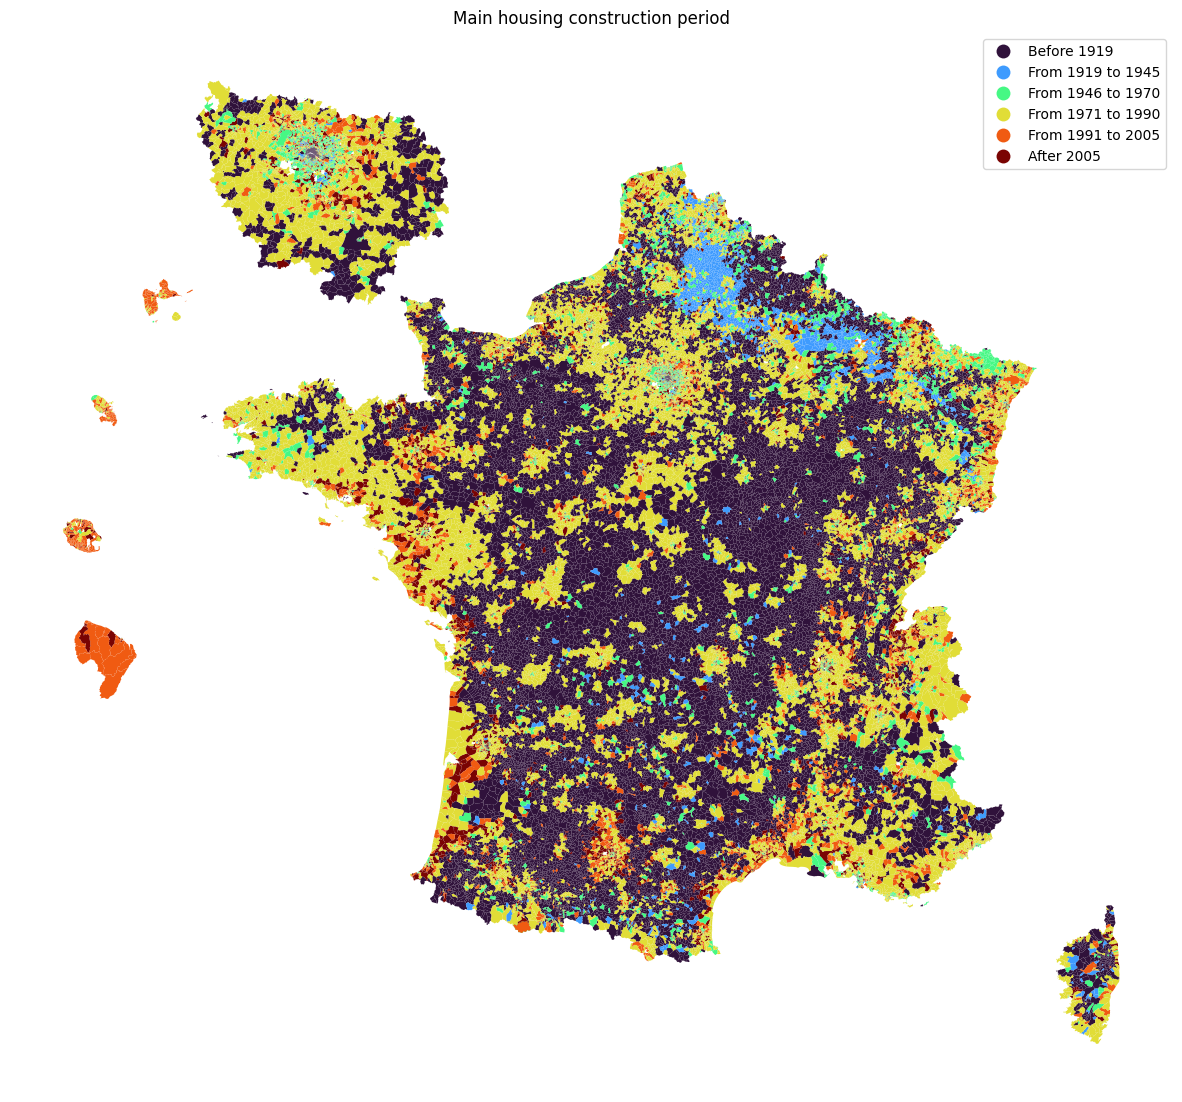

In [27]:
fig, ax = plt.subplots(1,1,figsize=[15,15])
dataFinal.plot(column='ACHL_label_en', cmap=cm.turbo,
               legend=True, ax=ax)
ax.set_axis_off()
ax.set(title='Main housing construction period')
plt.show()